In [1]:
import logging
import os
import numpy as np

from qcodes import Station, Measurement, load_or_create_experiment, load_by_id
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_dataset

from sim.qcodes_utils import dump_db
from sim.data_providers import QcodesDataProvider, Dependent2dDataProvider, PassthroughDataProvider
from sim.qcodes_mocks import MockDeviceInstrument, SimulationParameter
from sim.mock_devices import MockDevice, MockPin
from qcodes.utils.dataset import doNd


### Create a mock device (simulator) and qcodes adapter instrument

In [2]:
class MockChip(MockDevice):
    def __init__(self):
        super().__init__(
            "MockChip",
            [
                MockPin("Field"),
                MockPin("LeftBias"),
                MockPin("RightBias"),
                MockPin("Readout")
            ]
        )


class MockChipInstrument(MockDeviceInstrument):
    """ QCoDeS Mock Instrument that wraps a MockSingleQuantumDot device """

    def __init__(self, name: str = "MockSingleQuantumDotInstrument"):

        super().__init__(name, MockChip())
        mock = self.mock_device

        self.add_parameter(
            "Field",
            parameter_class=SimulationParameter,
            unit="T",
            sim_pin=mock["Field"],
        )
        self.add_parameter(
            "LeftBias",
            parameter_class=SimulationParameter,
            unit="V",
            sim_pin=mock["LeftBias"],
        )
        self.add_parameter(
            "RightBias",
            parameter_class=SimulationParameter,
            unit="V",
            sim_pin=mock["RightBias"],
        )
        self.add_parameter(
            "Readout",
            parameter_class=SimulationParameter,
            unit="e2/h",
            sim_pin=mock["Readout"],
        )


### Create the Station

In [3]:
# Create the station and add the mock quantum dot instrument
exp = load_or_create_experiment("simtest")
station = Station()

mock_instr = MockChipInstrument()
station.add_component(mock_instr, name="mock_chip")

# Get the simulator from the mock instrument for future use
sim = mock_instr.mock_device

In [4]:
from qcodes.utils.dataset.doNd import do2d, do1d

## 2D Measurement Test

In [5]:
synthetic2dData = Dependent2dDataProvider(sim["Field"], sim["RightBias"], value_provider=Dependent2dDataProvider.mul_values)

Starting experimental run with id: 246. 


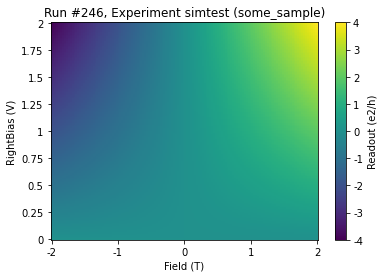

In [6]:
# Measure using synthetic data
sim["Readout"].set_data_provider(synthetic2dData)
result = do2d(mock_instr.Field, -2, 2, 140, 0.0,
              mock_instr.RightBias, 0, 2, 140, 0.0,
              *[mock_instr.Readout],
              do_plot = True)



{'MockSingleQuantumDotInstrument_Field': ParamSpec('MockSingleQuantumDotInstrument_Field', 'numeric', 'Field', 'T', inferred_from=[], depends_on=[]), 'MockSingleQuantumDotInstrument_RightBias': ParamSpec('MockSingleQuantumDotInstrument_RightBias', 'numeric', 'RightBias', 'V', inferred_from=[], depends_on=[]), 'MockSingleQuantumDotInstrument_Readout': ParamSpec('MockSingleQuantumDotInstrument_Readout', 'numeric', 'Readout', 'e2/h', inferred_from=[], depends_on=['MockSingleQuantumDotInstrument_Field', 'MockSingleQuantumDotInstrument_RightBias'])}


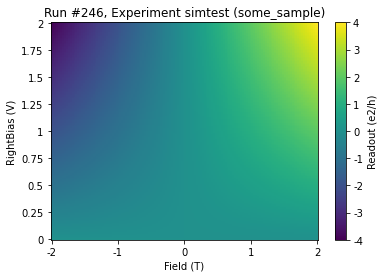

In [7]:
dataset = result[0]
_ = plot_dataset(dataset)
print(dataset.paramspecs)

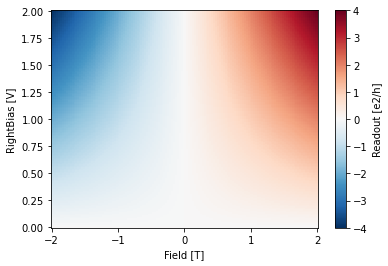

In [8]:
# Re-load the dataset as an XArray (via QCodesDataProvider) and plot the xarray version
db = r"C:\Users\jalee\experiments.db"
exp = "simtest"
param = "MockSingleQuantumDotInstrument_Readout"
run_id = dataset.run_id

qc_data_provider = QcodesDataProvider([sim["Field"], sim["RightBias"]], db, exp, run_id, param)
_ = qc_data_provider.raw_data["Readout"].plot()  # raw_data is the xarray

Starting experimental run with id: 247. 


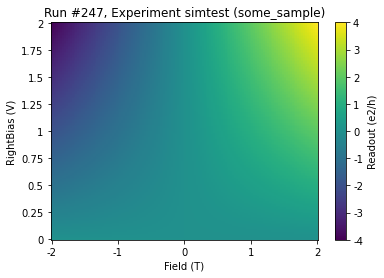

In [9]:
# Re-measure using the xarray based data provider
sim["Readout"].set_data_provider(qc_data_provider)
result = do2d(mock_instr.Field, -2, 2, 140, 0.0,
              mock_instr.RightBias, 0, 2, 140, 0.0,
              *[mock_instr.Readout],
              do_plot = True)

## 1D Measurement Test


In [10]:
synthetic1dData = PassthroughDataProvider(sim["Field"], scale = 3.0)

Starting experimental run with id: 248. 


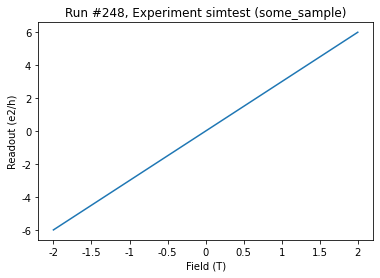

In [11]:
sim["Readout"].set_data_provider(synthetic1dData)
result = do1d(mock_instr.Field, -2, 2, 140, 0.0, *[mock_instr.Readout], do_plot = True)

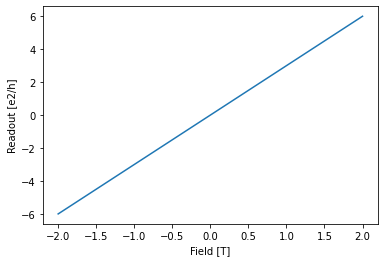

In [12]:
run_id = result[0].run_id

qc_data_provider = QcodesDataProvider([sim["Field"]], db, exp, run_id, param)
_ = qc_data_provider.raw_data["Readout"].plot()  # raw_data is the xarray

Starting experimental run with id: 249. 


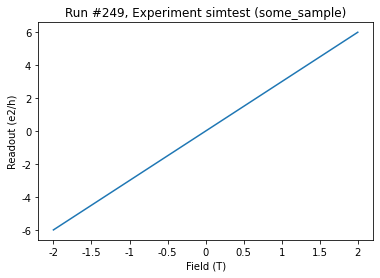

In [13]:
result = do1d(mock_instr.Field, -2, 2, 140, 0.0, *[mock_instr.Readout], do_plot = True)